In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

### Load train and test set

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### Dataset

In [3]:
class PeerReviewDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe.drop(columns=["label"]).values, dtype=torch.float32)
        self.y = torch.tensor(dataframe["label"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Neural Network

In [4]:
class PeerReviewNet(nn.Module):
    def __init__(self, input_dim):
        super(PeerReviewNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.output(x))

### Training Loop

In [5]:
def train_model(model, dataloader, epochs=10, lr=0.01):
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            y_batch = y_batch.float()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")


### Evaluate model

In [6]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch).squeeze()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Threshold sigmoid outputs at 0.5
    pred_labels = [1 if p >= 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, pred_labels)
    bacc = balanced_accuracy_score(all_labels, pred_labels)
    prec = precision_score(all_labels, pred_labels, zero_division=0)
    rec = recall_score(all_labels, pred_labels, zero_division=0)
    f1 = f1_score(all_labels, pred_labels, zero_division=0)

    print(f"Accuracy:  {acc:.4f}")
    print(f"B-Accuracy:  {bacc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    return {
        "accuracy": acc,
        "balanced_accuracy": bacc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

### Prepare data

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df.drop("label", axis=1))
X_test = scaler.transform(test_df.drop("label", axis=1))

train_df.loc[:, train_df.columns != "label"] = X_train
test_df.loc[:, test_df.columns != "label"] = X_test

In [8]:
# Create datasets
train_dataset = PeerReviewDataset(train_df)
test_dataset = PeerReviewDataset(test_df)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

### Training and Evaluation

In [9]:
input_dim = train_df.shape[1] - 1
model = PeerReviewNet(input_dim)

train_model(model, train_loader, epochs=120)

Epoch 1: Loss = 86.2121
Epoch 2: Loss = 75.5333
Epoch 3: Loss = 66.4387
Epoch 4: Loss = 57.5791
Epoch 5: Loss = 49.4486
Epoch 6: Loss = 45.3004
Epoch 7: Loss = 39.1944
Epoch 8: Loss = 32.7012
Epoch 9: Loss = 30.8462
Epoch 10: Loss = 27.6072
Epoch 11: Loss = 23.2306
Epoch 12: Loss = 23.4409
Epoch 13: Loss = 20.8235
Epoch 14: Loss = 18.6288
Epoch 15: Loss = 17.1006
Epoch 16: Loss = 15.6227
Epoch 17: Loss = 14.9467
Epoch 18: Loss = 14.2145
Epoch 19: Loss = 16.1870
Epoch 20: Loss = 14.8123
Epoch 21: Loss = 13.3564
Epoch 22: Loss = 11.9855
Epoch 23: Loss = 12.1046
Epoch 24: Loss = 11.2052
Epoch 25: Loss = 11.8998
Epoch 26: Loss = 11.8612
Epoch 27: Loss = 10.1235
Epoch 28: Loss = 10.5265
Epoch 29: Loss = 10.1001
Epoch 30: Loss = 8.3089
Epoch 31: Loss = 9.0321
Epoch 32: Loss = 8.9440
Epoch 33: Loss = 7.3859
Epoch 34: Loss = 7.8501
Epoch 35: Loss = 7.9479
Epoch 36: Loss = 8.1245
Epoch 37: Loss = 7.7650
Epoch 38: Loss = 7.1259
Epoch 39: Loss = 7.4510
Epoch 40: Loss = 7.6839
Epoch 41: Loss = 6.8

In [10]:
evaluate_model(model, test_loader)

Accuracy:  0.6569
B-Accuracy:  0.6365
Precision: 0.6357
Recall:    0.4852
F1 Score:  0.5503


{'accuracy': 0.6568501920614597,
 'balanced_accuracy': 0.6365087421694472,
 'precision': 0.6356589147286822,
 'recall': 0.48520710059171596,
 'f1': 0.5503355704697986}

### Feature Importance from First Hidden Layer

In [25]:
def compute_feature_importance(model):
    with torch.no_grad():
        weights = model.fc1.weight  # shape: (32, input_dim)
        importance = torch.sum(torch.abs(weights), dim=0)  # sum over 32 neurons
        normalized = importance / importance.sum()
    return normalized.numpy()  # returns shape: (input_dim,)

def plot_feature_importance(importance_scores, feature_names, top_n=20):
    # Create mapping
    feature_importance = {name: score for name, score in zip(feature_names, importance_scores)}
    
    # Sort by importance
    sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Unpack names and scores
    names, scores = zip(*sorted_items)
    
    # Plot
    height = max(4, top_n * 0.3)
    plt.figure(figsize=(10, height))
    plt.barh(range(len(names)), scores, color='skyblue')
    plt.yticks(range(len(names)), names)
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.xlabel("Normalized Importance Score")
    plt.title(f"Top {top_n} Important Features from First Layer")
    plt.tight_layout()
    plt.show()



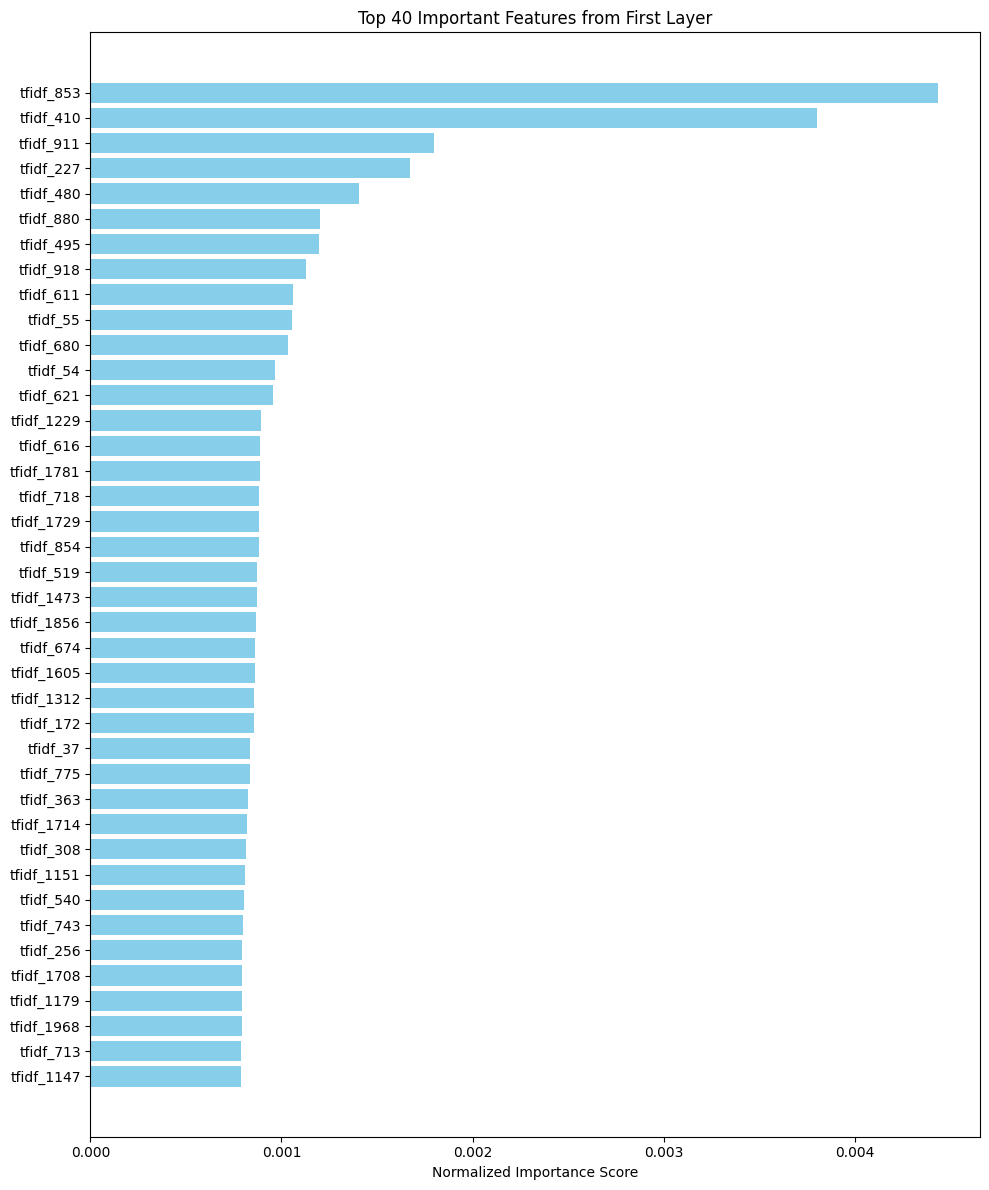

In [26]:
importance_scores = compute_feature_importance(model)
feature_names = train_df.drop(columns=["label"]).columns.tolist()
plot_feature_importance(importance_scores, feature_names, top_n=40)